# TUMOR METABOLISM COLOR CODING WITH FUSION OF COREGISTERD PET & CT DATA

## 1) Preprocessing Stage Using custom Data Pipeline

### Converting DICOM Images into Numpy arrays and storing them as compressed .pickle.gzip form

In [81]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [82]:
import DicomPipeLine 

In [83]:
source_path = r'F:\Final Year Project\Data Pipeline\Dev\Source'
processed_path = r'F:\Final Year Project\Data Pipeline\Dev\Preprocessed'
sub_folders_to_scan_for = ['2','3','4','5']

#### Creating Path Settings Object to access the Source and destination folders

In [84]:
path_obj = DicomPipeLine.Path_Settings(    
                source_path, 
                processed_path, 
                sub_folders_to_scan_for
            )

In [85]:
path_obj.get_all_source_folders(print_progress = True)[0:4]

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2007.80it/s]

- Found 2 folders with a total of 8 scans


[[<DirEntry '1.3.12.2.1107.5.1.4.11050.30000021082603485362500000022'>,
  [<DirEntry '2'>, <DirEntry '3'>, <DirEntry '4'>, <DirEntry '5'>]],
 [<DirEntry '1.3.12.2.1107.5.1.4.11050.30000021092104085307800000013'>,
  [<DirEntry '2'>, <DirEntry '3'>, <DirEntry '4'>, <DirEntry '5'>]]]

In [86]:
# these are the attributes to extract from each patient
dcm_attributes_level_0 = [
    'PatientSize',
    'PatientWeight',
    'StudyDate', 
    'StudyTime',
    'InstitutionAddress', 
    'InstitutionName',
    'Manufacturer', 
    'ManufacturerModelName'
]

# these are the attributes to extract from each scan per patient
dcm_attributes_level_1 = [
    'AcquisitionDate', 
    'AcquisitionTime', 
    'PatientPosition',
    'SeriesDescription',
    'SeriesDate',
    'SeriesTime'
]

# these are the attributes to extract from each frame per scan 
dcm_attributes_level_2 = [
    'Rows',
    'Columns',
    'InstanceNumber',
    'PixelSpacing',
    'ImagePositionPatient',
    'ImageOrientationPatient',
    'SliceLocation',
    'SliceThickness'
]


#### specify all 3 levels of attributes in a array

In [87]:

dcm_attributes = [ dcm_attributes_level_0, dcm_attributes_level_1, dcm_attributes_level_2 ]


#### Create the DCM -> NPY class object to convert each .dcm frame to numpy arrays

In [88]:
dcm_to_numpy_obj = DicomPipeLine.DCM_Input_To_NPY_Output(path_obj, dcm_attributes)

#### Iterating over the source folders to convert them to numpy database

In [89]:
dcm_to_numpy_obj.iterate(2)

- specified number of folders 2 exceeds total folders 1
- Hence processing only one folder
- processing folder F:\Final Year Project\Data Pipeline\Dev\Source\1.3.12.2.1107.5.1.4.11050.30000021092104085307800000013


100%|███████████████████████████████████████████████████████████████████████████████| 658/658 [00:03<00:00, 166.23it/s]


- Saving Processed scans ['CT PLAIN', 'CT ARTERIAL', 'CT VENOUS', 'PET WB  (AC)'] ....


#### Creating an object to stream through the processed data

In [90]:
streamer = DicomPipeLine.Stream_Data(path_obj)

#### Fetching the CT & PET scans 

In [91]:
ct_array_1 = streamer.get('1', 'CT PLAIN')
pet_array_1 = streamer.get('1', 'PET WB  (AC)')

F:\Final Year Project\Data Pipeline\Dev\Preprocessed\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\Dev\Preprocessed\1\PET WB  (AC).pickle.gzip


In [92]:
ct_array_2 = streamer.get('2', 'CT PLAIN')
pet_array_2 = streamer.get('2', 'PET WB  (AC)')

F:\Final Year Project\Data Pipeline\Dev\Preprocessed\2\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\Dev\Preprocessed\2\PET WB  (AC).pickle.gzip


In [93]:
# accessing frame number 363

ct_1 = ct_array_1[362]
pet_1 = pet_array_1[362]

ct_2 = ct_array_2[362]
pet_2 = pet_array_2[362]

#### ploting and visualising the scans

Normal Liver


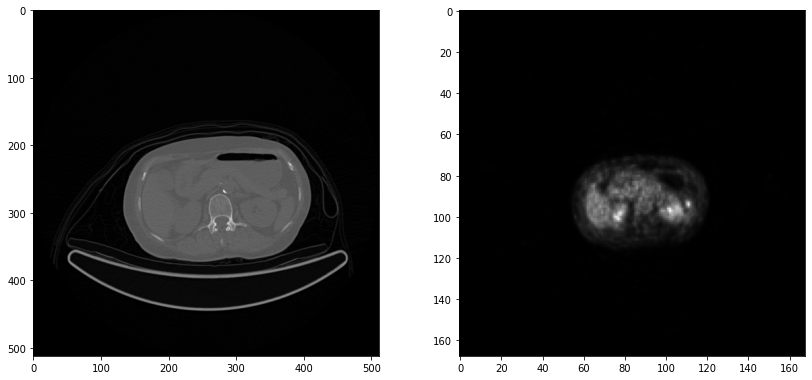

In [94]:
%matplotlib inline
plt.figure(figsize = (14,14))

print("Normal Liver")
plt.subplot(2,2,1)
plt.imshow(ct_1, cmap = 'gray')
plt.subplot(2,2,2)
plt.imshow(pet_1, cmap = 'gray')


Tumor Liver


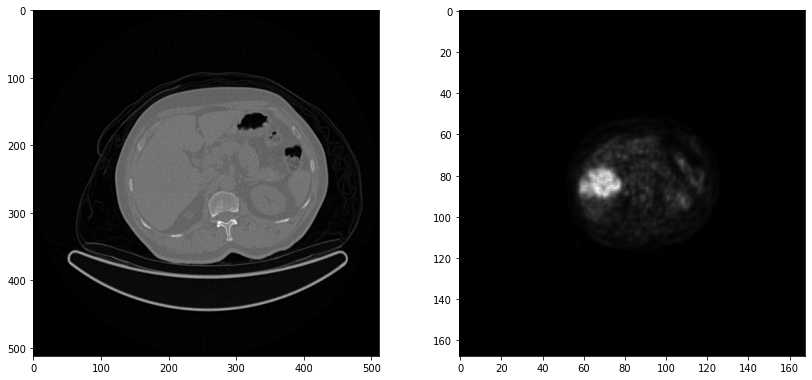

In [95]:
%matplotlib inline
plt.figure(figsize = (14,14))

print("Tumor Liver")
plt.subplot(2,2,3)
plt.imshow(ct_2, cmap = 'gray')
plt.subplot(2,2,4)
plt.imshow(pet_2, cmap = 'gray')

#### Function to normalize the data from uint16 to uint8 type

In [96]:
def NORMALIZE(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U)

#### Plot function

In [97]:
%matplotlib inline
def PLOT(img, cmap, f_size):
    plt.figure(figsize = f_size)
    plt.imshow(img, cmap = cmap)

In [98]:
from skimage.transform import resize

#### comparing different image enhancement techniques

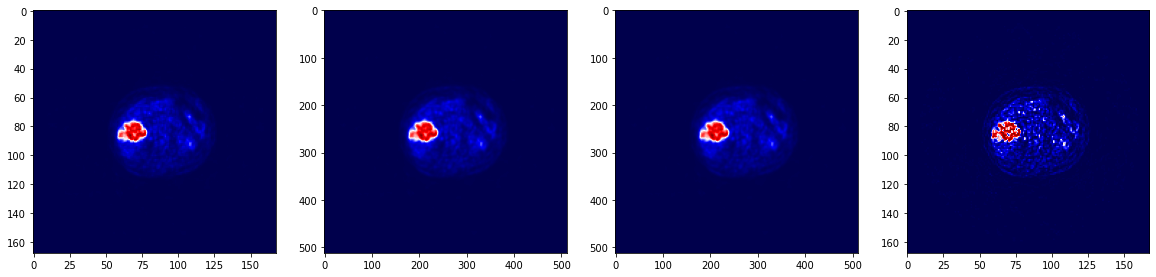

In [19]:

pet = NORMALIZE(pet_2)
ct = ct_2

test_img_t = resize(pet, (ct.shape[0], ct.shape[1]),anti_aliasing=True)
test_img_f = resize(pet, (ct.shape[0], ct.shape[1]),anti_aliasing=False)

kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

test_img_s = cv2.filter2D(src=pet, ddepth=-1, kernel=kernel)

plt.figure(figsize = (20,20))
plt.subplot(1,4,1)
plt.imshow(pet, cmap = 'seismic')
plt.subplot(1,4,2)
plt.imshow(test_img_t, cmap = 'seismic')
plt.subplot(1,4,3)
plt.imshow(test_img_f, cmap = 'seismic')
plt.subplot(1,4,4)
plt.imshow(test_img_s, cmap = 'seismic')

# 

## 2) Image Registration Stage - For CT & PET frame allignment

#### Interactive plot method to mark the points 

In [99]:
%matplotlib notebook
def Interactive_Plot(a_args, b_args, num_pts, fig_size):
    
    img_a, cmap_a = a_args
    img_b, cmap_b = b_args
    
    a_pts = []
    b_pts = []
    
    fig = plt.figure(figsize = fig_size)
    a = fig.add_subplot(121)
    a.set_title('img_a')
    a.imshow(img_a, cmap = cmap_a)
    b = fig.add_subplot(122)
    b.set_title('img_b')
    b.imshow(img_b, cmap = cmap_b)
    
    def onclick(event):
        if event.inaxes == a:
            if event.button == 1:
                if len(a_pts) < num_pts:
                    x, y = int(event.xdata), int(event.ydata)
                    a_pts.append((x, y))
                    a.plot(x, y, 'gx', markersize = 14)
                    fig.canvas.draw()
                    
            print(event.button)

                    
        elif event.inaxes == b:
            if event.button == 1:
                if len(b_pts) < num_pts:
                    x, y = int(event.xdata), int(event.ydata)
                    b_pts.append((x, y))
                    b.plot(x, y, 'gx', markersize = 14)
                    fig.canvas.draw()
                
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    return a_pts, b_pts

<IPython.core.display.Javascript object>


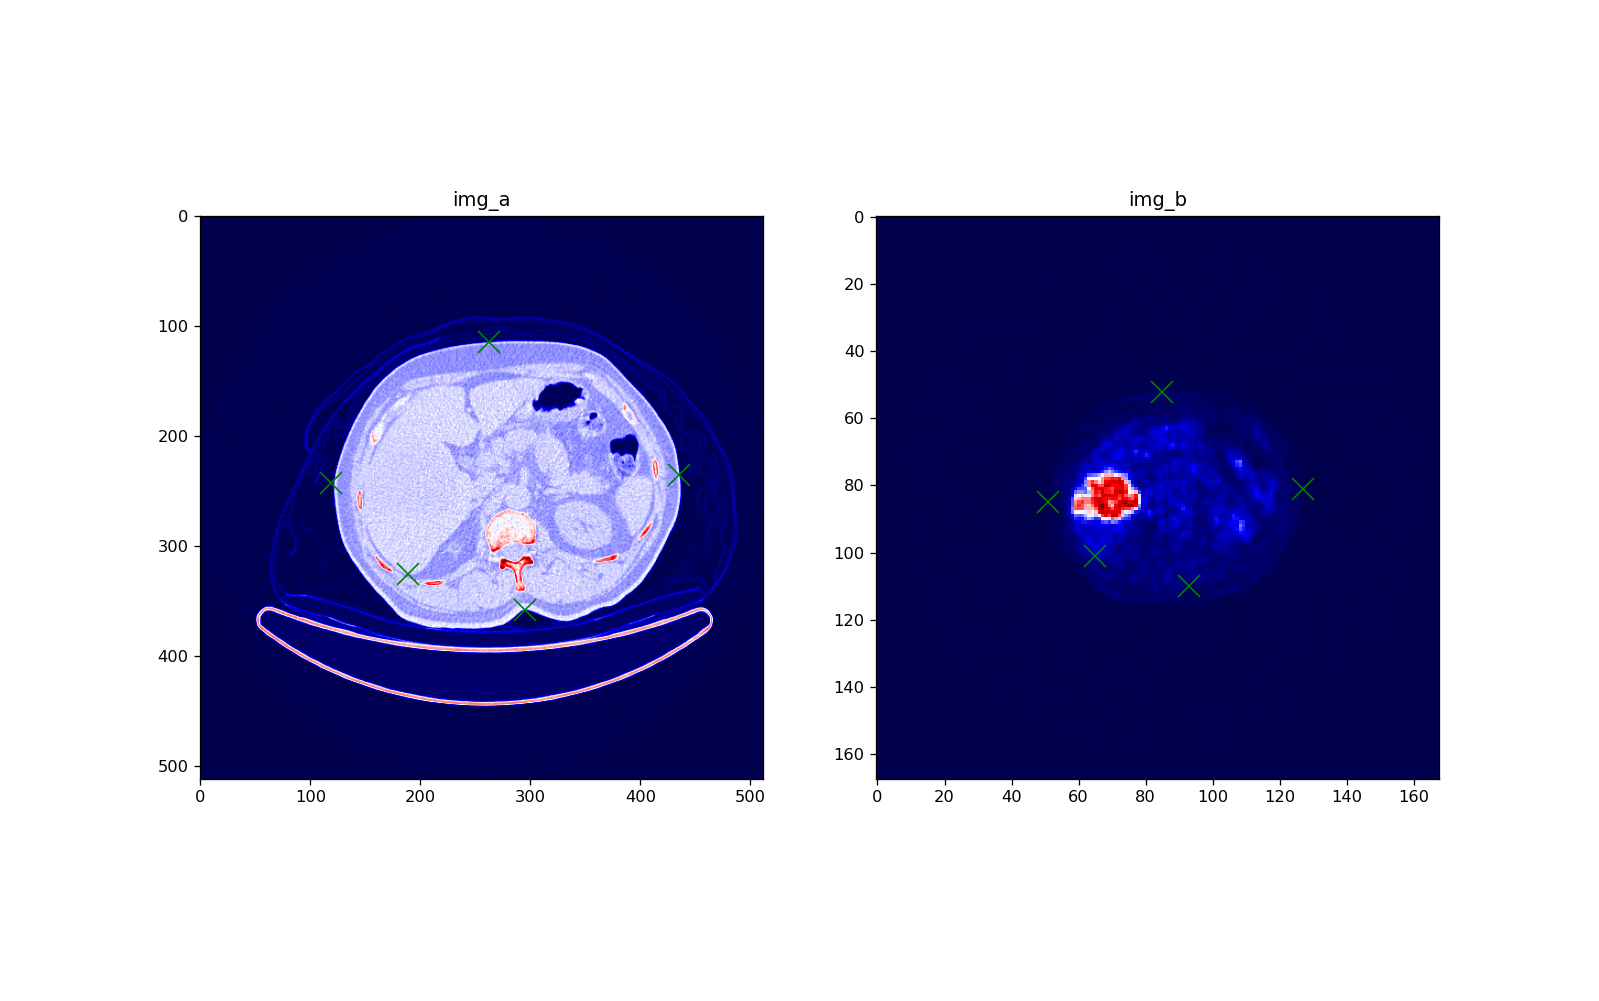

In [100]:
ct_arguments = (ct, 'seismic')
pt_arguments = (pet, 'seismic')
num_pts = 5
figure_size = (10, 10)
ct_pts, pt_pts = Interactive_Plot(ct_arguments, pt_arguments, num_pts, figure_size)

#### storing the specified points in an array

In [101]:
ct_pts = np.asarray(ct_pts)
ct_pts

array([[262, 114],
       [119, 243],
       [435, 235],
       [295, 358],
       [189, 325]])

In [102]:
pt_pts = np.asarray(pt_pts)
pt_pts

array([[ 85,  52],
       [ 51,  85],
       [127,  81],
       [ 93, 110],
       [ 65, 101]])

#### saving the points for further Iteration

In [103]:
streamer.save_transform_points('2', ct, pet, ct_pts, pt_pts)

#### access the registered images 

In [104]:
ct_frames, pet_frames = streamer.get_scans('2', 'CT PLAIN', 'PET WB  (AC)', transform = True)

F:\Final Year Project\Data Pipeline\Dev\Preprocessed\2\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\Dev\Preprocessed\2\PET WB  (AC).pickle.gzip


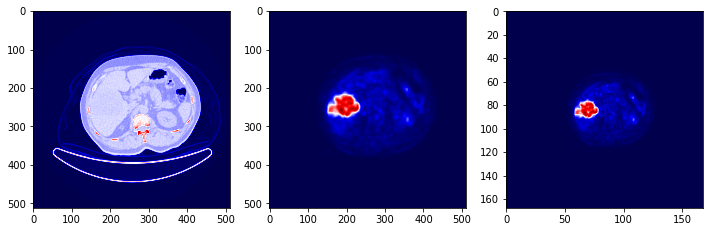

In [108]:
%matplotlib inline
plt.figure(figsize = (12, 12))

plt.subplot(2,3,1)
plt.imshow(ct_frames[362], cmap = 'seismic')
plt.subplot(2,3,2)
plt.imshow(pet_frames[362], cmap = 'seismic')
plt.subplot(2,3,3)
plt.imshow(pet, cmap = 'seismic')

#### now the data is ready for fusion

###  

## 3) Image Fusion & Color coding Techniques

#### fusion using pywalets 

In [33]:
import pywt

In [34]:
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

In [35]:
def Fusion_Method_1(img_a, img_b):
    
    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # Read the two image
    I2 = img_a
    I1 = img_b

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'haar'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # print(cooef1)
    # print(cooef2)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 3 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we need to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage

In [36]:
def visualize(frames, normalize = False, window_name = 'un_named'):
    
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 500,500)

    i = 0
    while True:
        
        frame = frames[i]
        
        if normalize == True:
            frame = NORMALIZE(frame)

        cv2.imshow(window_name, frame)

        current_key = cv2.waitKey(0)
        if current_key & 0xFF == ord('b'):
            if i > 0: 
                i -= 1 
            continue
        if current_key & 0xFF == ord('q'):
            break
        if current_key & 0xFF == ord('f'):
            if i < len(frames) - 1 :
                i += 1

    cv2.destroyAllWindows()
    return

In [37]:
ct_frames.shape, pet_frames.shape

((658, 512, 512), (658, 512, 512))

In [38]:
ct_frames.dtype, pet_frames.dtype

(dtype('uint16'), dtype('uint16'))

In [39]:
visualize(ct_frames, normalize = True, window_name = 'ct')
visualize(pet_frames, normalize = True, window_name = 'pet')

In [61]:
def fusion(ct_frames, pet_frames, fusion_method, normalize = True):
    
    fused_frames = []
    for x, y in zip(ct_frames, pet_frames):
        if normalize == True:
            x = NORMALIZE(x)
            y = NORMALIZE(y)
            fused = fusion_method(x, y)
        fused_frames.append(fused)
    return fused_frames
        

In [69]:
fused_frames = fusion(ct_frames, pet_frames, Fusion_Method_1)

In [70]:
fused_frames[65].dtype

dtype('uint8')

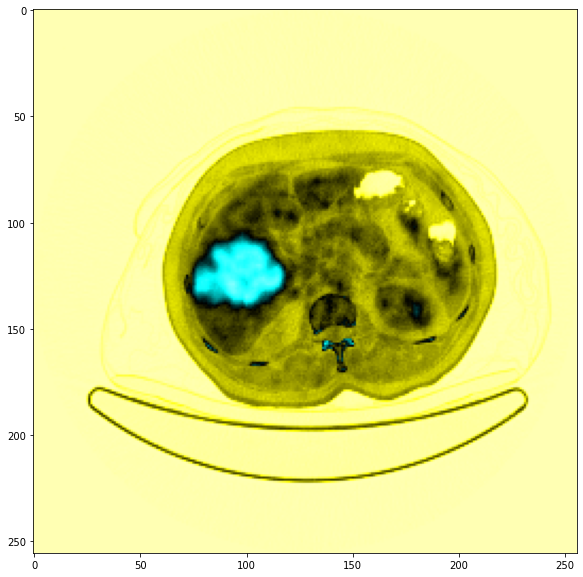

In [80]:
%matplotlib inline
# kernel = np.array([[0, -1, 0],
#                    [-1, 5,-1],
#                    [0, -1, 0]])

# test = cv2.filter2D(src=np.invert(fused_frames[362]), ddepth=-1, kernel=kernel)
PLOT(fused_frames[362], 'seismic', (10, 10))

In [72]:
visualize( fused_frames, normalize = False, window_name = 'ct')

In [73]:
cmap = plt.get_cmap('seismic')

In [74]:

for i, frame in enumerate(fused_frames):
    frame = cmap(frame)
    frame = (frame[:, :, :3] * 255).astype(np.uint8)
    fused_frames[i] = np.invert(frame)

In [75]:
visualize( fused_frames, normalize = False, window_name = 'ct')

In [47]:
import SimpleITK as sitk
import os

In [48]:
for i,x in enumerate(fused_frames):
    img = sitk.GetImageFromArray(x)
    path = os.path.join(r'F:\Final Year Project\Data Pipeline\Dev\Reconstructed', f'{i+1}.dcm')
    sitk.WriteImage(img, path)
    